In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from scipy.stats import norm
import matplotlib.pyplot as plt

# Market parameters
r = 0.05          # Risk-free rate
sigma = 0.2       # Volatility
S0 = 1.0          # Normalized initial stock price
T = 1.0           # Time to maturity
M = 50            # Number of time steps
dt = T / M        # Time step size

# Option parameters
K = 1.0           # Normalized strike price

def simulate_asset_paths(S0, r, sigma, T, M, N, seed=None):
    if seed is not None:
        np.random.seed(seed)
    dt = T / M
    t_grid = np.linspace(0, T, M + 1)
    S = np.zeros((N, M + 1))
    S[:, 0] = S0
    for t in range(1, M + 1):
        z = np.random.standard_normal(N)
        S[:, t] = S[:, t - 1] * np.exp(
            (r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z
        )
    return S, t_grid 

def build_neural_network(input_dim, hidden_units):
    initializer = keras.initializers.RandomUniform(minval=-0.1, maxval=0.1)
    model = keras.Sequential([
        keras.layers.Dense(hidden_units, activation='relu', input_shape=(input_dim,),
                           kernel_initializer=initializer, bias_initializer='zeros'),
        keras.layers.Dense(1, activation='linear', kernel_initializer=initializer, bias_initializer='zeros')
    ])
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    return model

def compute_conditional_expectations(S_t_prev, model, r, sigma, dt):
    # Extract weights and biases
    W1, b1 = model.layers[0].get_weights()
    W2, b2 = model.layers[1].get_weights()
    hidden_units = W1.shape[1]
    N = S_t_prev.shape[0]
    
    # Compute parameters for the normal distribution of log(S_t)
    mu_Y = np.log(S_t_prev) + (r - 0.5 * sigma ** 2) * dt  # Shape: (N,)
    sigma_Y = sigma * np.sqrt(dt)  # Scalar
    
    # Initialize expected values
    E_t = np.zeros(N)
    
    # For each neuron in the hidden layer
    for i in range(hidden_units):
        w_i = W1[0, i]  # Since input_dim = 1
        b_i = b1[i]
        omega_i = W2[i, 0]
        
        # Parameters of Z_i = w_i * Y + b_i
        mu_Z_i = w_i * mu_Y + b_i
        sigma_Z_i = abs(w_i) * sigma_Y
        
        # Avoid division by zero in case sigma_Z_i is zero
        z = np.zeros(N)
        non_zero_sigma = sigma_Z_i > 1e-8  # Small threshold to avoid division by zero
        z[non_zero_sigma] = mu_Z_i[non_zero_sigma] / sigma_Z_i[non_zero_sigma]
        
        # Compute E[max(Z_i, 0)]
        E_max_Z_i = np.zeros(N)
        # For non-zero sigma_Z_i
        E_max_Z_i[non_zero_sigma] = (
            sigma_Z_i[non_zero_sigma] * norm.pdf(-z[non_zero_sigma]) +
            mu_Z_i[non_zero_sigma] * norm.cdf(z[non_zero_sigma])
        )
        # For zero sigma_Z_i, E[max(Z_i, 0)] = max(mu_Z_i, 0)
        E_max_Z_i[~non_zero_sigma] = np.maximum(mu_Z_i[~non_zero_sigma], 0)
        
        # Update the expected value
        E_t += omega_i * E_max_Z_i
    
    # Add bias of the output layer
    E_t += b2
    return E_t

def rlnn_pricing(S_paths, K, r, sigma, T, M, exercise_times, hidden_units=32, epochs=50):
    N = S_paths.shape[0]
    dt = T / M
    discount_factor = np.exp(-r * dt)
    t_grid = np.linspace(0, T, M + 1)
    
    # Initialize option values at maturity
    V = np.maximum(S_paths[:, -1] - K, 0)
    prices = [np.mean(V * np.exp(-r * T))]
    continuation_values = np.zeros_like(S_paths)
    continuation_values[:, -1] = V
    model_list = []
    
    # Early stopping callback
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Loop backward in time
    for t in range(M, 0, -1):
        current_time = t_grid[t]
        
        # Decide whether this is an exercise time
        if np.any(np.isclose(current_time, exercise_times)):
            # This is an exercise time
            
            # Prepare training data at time t
            X_train = np.log(S_paths[:, t]).reshape(-1, 1)
            y_train = continuation_values[:, t]
            
            # Split into training and validation sets
            split_index = int(0.7 * N)
            X_train_split, X_val_split = X_train[:split_index], X_train[split_index:]
            y_train_split, y_val_split = y_train[:split_index], y_train[split_index:]
            
            # Build and train the neural network
            model = build_neural_network(input_dim=1, hidden_units=hidden_units)
            model.fit(
                X_train_split, y_train_split,
                validation_data=(X_val_split, y_val_split),
                epochs=epochs, batch_size=4096, verbose=0,
                callbacks=[early_stopping]
            )
            model_list.insert(0, model)
            
            # Compute continuation values at time t-1
            S_t_prev = S_paths[:, t - 1]
            E_t = compute_conditional_expectations(S_t_prev, model, r, sigma, dt)
            Q_t_prev = np.exp(-r * dt) * E_t  # Discount the expected value
            
            # Immediate exercise value
            exercise = np.maximum(S_t_prev - K, 0)
            
            # Decide whether to exercise or continue
            V = np.maximum(exercise, Q_t_prev)
            continuation_values[:, t - 1] = V
            
            # Store the option price at this time step
            price = np.mean(V * np.exp(-r * t_grid[t - 1]))
            prices.insert(0, price)
        else:
            # Not an exercise time
            # Continuation value is discounted value of V at time t
            V = continuation_values[:, t] * discount_factor
            continuation_values[:, t - 1] = V
            # Store the option price at this time step
            price = np.mean(V * np.exp(-r * t_grid[t - 1]))
            prices.insert(0, price)
    
    # The option price at t=0
    option_price = prices[0]
    return option_price, prices, continuation_values, model_list

def calculate_lower_bound(S_paths, K, r, T, M, exercise_times, model_list, sigma):
    N = S_paths.shape[0]
    dt = T / M
    discount_factors = np.exp(-r * dt * np.arange(M + 1))
    V = np.zeros(N)
    for i in range(N):
        exercised = False
        for t in range(M):
            current_time = t * dt
            if np.any(np.isclose(current_time, exercise_times)):
                S = S_paths[i, t]
                immediate_exercise = max(S - K, 0)
                # Get the corresponding model
                model_index = np.where(np.isclose(exercise_times, current_time))[0][0]
                model = model_list[model_index]
                continuation = np.exp(-r * dt) * compute_conditional_expectations(
                    np.array([S]), model, r, sigma, dt
                )[0]
                if immediate_exercise > continuation:
                    V[i] = immediate_exercise * discount_factors[t]
                    exercised = True
                    break
        if not exercised:
            V[i] = max(S_paths[i, -1] - K, 0) * discount_factors[-1]
    lower_bound = np.mean(V)
    return lower_bound

def calculate_upper_bound(S_paths, K, r, T, M, exercise_times, model_list, sigma):
    N = S_paths.shape[0]
    dt = T / M
    discount_factors = np.exp(-r * dt * np.arange(M + 1))
    cashflows = np.zeros(N)
    for i in range(N):
        martingale = 0
        payoff = 0
        continuation = 0
        for t in range(M):
            current_time = t * dt
            if np.any(np.isclose(current_time, exercise_times)):
                S = S_paths[i, t]
                # Get the corresponding model
                model_index = np.where(np.isclose(exercise_times, current_time))[0][0]
                model = model_list[model_index]
                continuation_prev = continuation
                continuation = np.exp(-r * dt) * compute_conditional_expectations(
                    np.array([S]), model, r, sigma, dt
                )[0]
                
                if t > 0:
                    # Update martingale
                    delta_martingale = continuation - continuation_prev
                    martingale += delta_martingale * discount_factors[t]
                
                immediate_exercise = max(S - K, 0)
                if immediate_exercise > continuation:
                    payoff = immediate_exercise * discount_factors[t]
                    break
        else:
            payoff = max(S_paths[i, -1] - K, 0) * discount_factors[-1]
        
        cashflows[i] = payoff - martingale
    upper_bound = np.mean(cashflows)
    return upper_bound


def bermudan_option_binomial(S0, K, r, sigma, T, M, option_type='call', exercise_times=None):
    dt = T / M
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    q = (np.exp(r * dt) - d) / (u - d)
    
    # Initialize asset prices at maturity
    asset_prices = np.zeros(M + 1)
    asset_prices[0] = S0 * d ** M
    for i in range(1, M + 1):
        asset_prices[i] = asset_prices[i - 1] * (u / d)
    
    # Initialize option values at maturity
    if option_type == 'call':
        option_values = np.maximum(asset_prices - K, 0)
    elif option_type == 'put':
        option_values = np.maximum(K - asset_prices, 0)
    
    # To store option prices at each exercise time
    binomial_prices_over_time = []
    exercise_times_set = set(np.round(exercise_times / dt).astype(int))  # Round to match time steps
    
    # Work backwards through the tree
    for m in range(M - 1, -1, -1):
        # Compute option values at nodes
        option_values = np.exp(-r * dt) * (q * option_values[1:] + (1 - q) * option_values[:-1])
        
        # Reduce asset_prices to match the size of option_values
        asset_prices = asset_prices[:m + 1]
        
        # Early exercise at exercise dates
        if m in exercise_times_set:
            if option_type == 'call':
                exercise_values = np.maximum(asset_prices - K, 0)
            elif option_type == 'put':
                exercise_values = np.maximum(K - asset_prices, 0)
            option_values = np.maximum(option_values, exercise_values)

            # Store the price at this exercise point
            binomial_prices_over_time.insert(0, option_values[0])  # Store the price at this exercise time
    
    # Ensure all exercise times are represented in the list (fill with final price if needed)
    while len(binomial_prices_over_time) < len(exercise_times):
        binomial_prices_over_time.insert(0, option_values[0])
    
    return option_values[0], binomial_prices_over_time


RLNN Bermudan Call Option Price: 0.0251
Binomial Bermudan Call Option Price at t=0: 0.1045
Lower Bound Estimate: 0.0441
Upper Bound Estimate: 0.0305


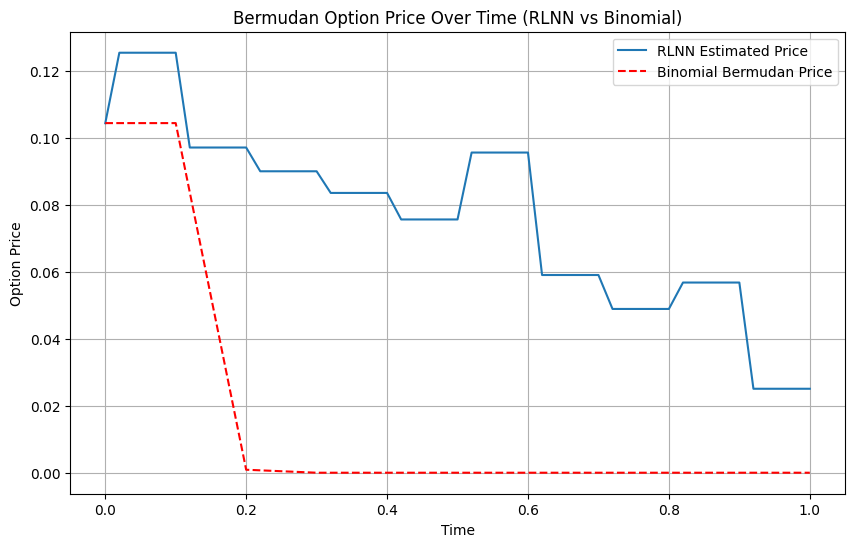

In [30]:
# Now let's run the RLNN pricing and compare with binomial prices over time

# Number of simulated paths for training
N_train = 5000
S_paths_train, time_grid = simulate_asset_paths(S0, r, sigma, T, M, N_train, seed=42)

# Define exercise times (Bermudan option exercise opportunities)
exercise_times = np.linspace(0, T, 10 + 1)  # 10 equally spaced exercise times, including t=0

# Run RLNN pricing
rlnn_price, rlnn_prices, continuation_values, model_list = rlnn_pricing(
    S_paths_train, K, r, sigma, T, M,
    exercise_times=exercise_times,
    hidden_units=32,
    epochs=50
)

print(f"RLNN Bermudan Call Option Price: {rlnn_price:.4f}")

# Binomial Bermudan option pricing with prices at each exercise time
binomial_price, binomial_prices_over_time = bermudan_option_binomial(S0, K, r, sigma, T, 500, option_type='call', exercise_times=exercise_times)
print(f"Binomial Bermudan Call Option Price at t=0: {binomial_price:.4f}")

# Simulate paths for lower and upper bound estimation
N_bounds = 5000
S_paths_bounds, _ = simulate_asset_paths(S0, r, sigma, T, M, N_bounds, seed=123)

lower_bound = calculate_lower_bound(
    S_paths_bounds, K, r, T, M, exercise_times, model_list, sigma
)
upper_bound = calculate_upper_bound(
    S_paths_bounds, K, r, T, M, exercise_times, model_list, sigma
)

print(f"Lower Bound Estimate: {lower_bound:.4f}")
print(f"Upper Bound Estimate: {upper_bound:.4f}")

# Plotting the RLNN option price over time with Binomial comparison
time_grid = np.linspace(0, T, M + 1)
plt.figure(figsize=(10, 6))
plt.plot(time_grid, rlnn_prices[::-1], label='RLNN Estimated Price')
plt.plot(exercise_times, binomial_prices_over_time, label='Binomial Bermudan Price', linestyle='--', color='red')
plt.title('Bermudan Option Price Over Time (RLNN vs Binomial)')
plt.xlabel('Time')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True)
plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step


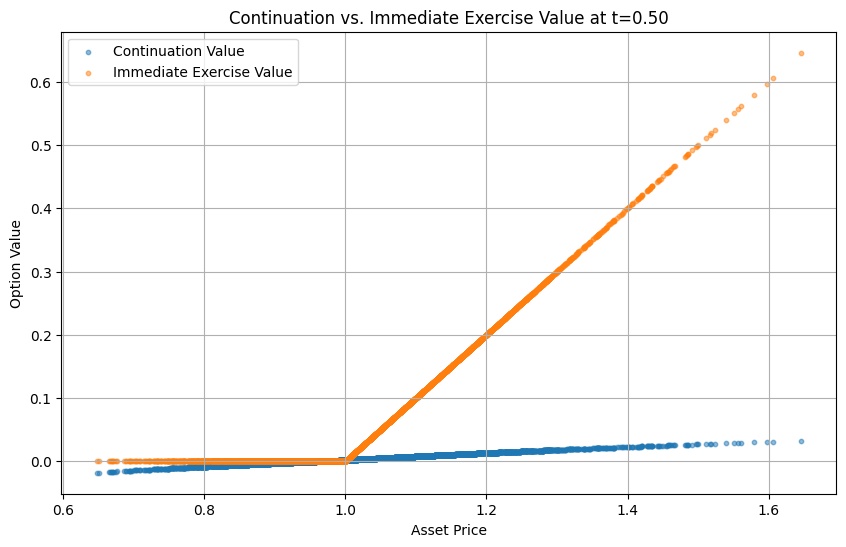

In [31]:
# Plot Continuation vs Immediate Exercise Value at a specific exercise time
t_exercise = exercise_times[5]  # Choose the 5th exercise time
t_index = int(t_exercise / dt)
S_t = S_paths_train[:, t_index]
V_t = continuation_values[:, t_index]
exercise = np.maximum(S_t - K, 0)

# Build and train the neural network at t_index
X_train = np.log(S_t).reshape(-1, 1)
y_train = continuation_values[:, t_index]

# Use the corresponding model from model_list
model_index = np.where(np.isclose(exercise_times, t_exercise))[0][0]
model = model_list[model_index]

# Predict continuation values
continuation = model.predict(np.log(S_t).reshape(-1, 1)).flatten()

plt.figure(figsize=(10, 6))
plt.scatter(S_t, continuation, label='Continuation Value', alpha=0.5, s=10)
plt.scatter(S_t, exercise, label='Immediate Exercise Value', alpha=0.5, s=10)
plt.title(f'Continuation vs. Immediate Exercise Value at t={t_exercise:.2f}')
plt.xlabel('Asset Price')
plt.ylabel('Option Value')
plt.legend()
plt.grid(True)
plt.show()

Testing with strike K=0.8


c:\Users\nitai\anaconda3\envs\General\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


RLNN Price: 0.203838, Binomial Price: 0.245898
Testing with strike K=0.9
RLNN Price: 0.104731, Binomial Price: 0.166987
Testing with strike K=1.0
RLNN Price: 0.042234, Binomial Price: 0.104466
Testing with strike K=1.1
RLNN Price: 0.018786, Binomial Price: 0.060422
Testing with strike K=1.2
RLNN Price: 0.002926, Binomial Price: 0.032466


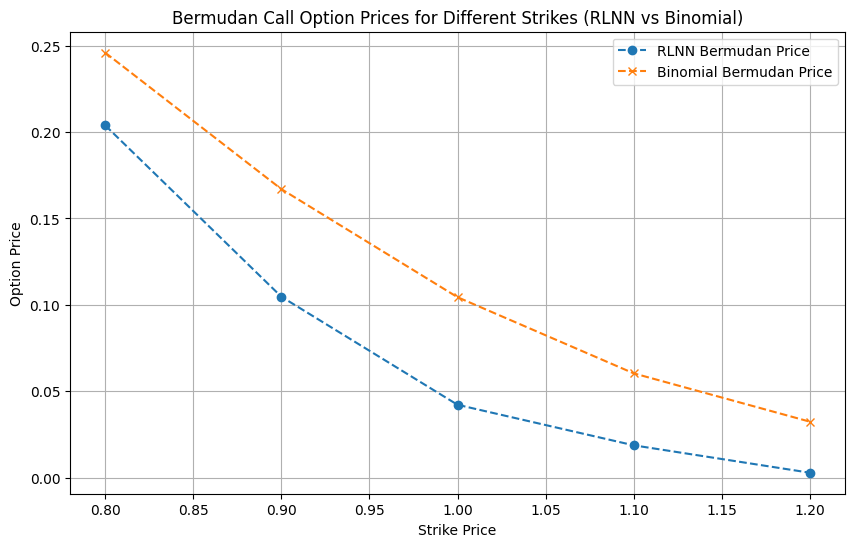

In [33]:
# Comparing RLNN and Binomial Bermudan Prices for Different Strikes
strikes = [0.8, 0.9, 1.0, 1.1, 1.2]
rlnn_prices_by_strike = []
binomial_prices_by_strike = []

for K_test in strikes:
    print(f"Testing with strike K={K_test}")
    # RLNN pricing
    S_paths_train, _ = simulate_asset_paths(S0, r, sigma, T, M, N_train, seed=42)
    rlnn_price, _, _, _ = rlnn_pricing(
        S_paths_train, K_test, r, sigma, T, M,
        exercise_times=exercise_times,
        hidden_units=32,
        epochs=50
    )
    rlnn_prices_by_strike.append(rlnn_price)
    
    # Binomial pricing
    binomial_price, _ = bermudan_option_binomial(S0, K_test, r, sigma, T, 500, option_type='call', exercise_times=exercise_times)
    binomial_prices_by_strike.append(binomial_price)
    
    print(f"RLNN Price: {rlnn_price:.6f}, Binomial Price: {binomial_price:.6f}")

# Plotting RLNN and Binomial Bermudan Prices for Different Strikes
plt.figure(figsize=(10, 6))
plt.plot(strikes, rlnn_prices_by_strike, label='RLNN Bermudan Price', marker='o', linestyle='--')
plt.plot(strikes, binomial_prices_by_strike, label='Binomial Bermudan Price', marker='x', linestyle='--')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title('Bermudan Call Option Prices for Different Strikes (RLNN vs Binomial)')
plt.legend()
plt.grid(True)
plt.show()


In [40]:
def test_neural_network_shapes(input_dim, hidden_units):
    model = build_neural_network(input_dim, hidden_units)
    # Get weights and biases from each layer
    W1, b1 = model.layers[0].get_weights()
    W2, b2 = model.layers[1].get_weights()
    
    # Check shapes of the first layer weights and biases
    assert W1.shape == (input_dim, hidden_units), \
        f"Incorrect W1 shape: expected {(input_dim, hidden_units)}, got {W1.shape}"
    assert b1.shape == (hidden_units,), \
        f"Incorrect b1 shape: expected {(hidden_units,)}, got {b1.shape}"
    
    # Check shapes of the second layer weights and biases
    assert W2.shape == (hidden_units, 1), \
        f"Incorrect W2 shape: expected {(hidden_units, 1)}, got {W2.shape}"
    assert b2.shape == (1,), \
        f"Incorrect b2 shape: expected {(1,)}, got {b2.shape}"


In [43]:
# Tests

#Single-Asset Bermudan Option:
test_neural_network_shapes(input_dim=1, hidden_units=32)

# Basket Option on Five Assets:
test_neural_network_shapes(input_dim=5, hidden_units=64)

# Max Option on d Assets:
d = 10
test_neural_network_shapes(input_dim=d, hidden_units=128)

